# Automating a Kerbal trip to the moon with KRPC


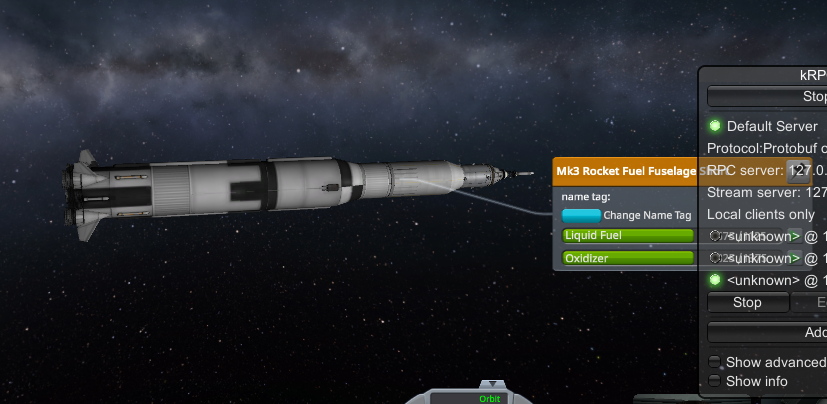

## Introduction
Kerbal Space Program (KSP) (1.0) is a semi-physics-realistic space exploration simulation. While it is not realistic enough to plan actual space missions, it is a fun educational tool that can get us started. With the kRPC mod (remote procedure call, which enables programatic interaction with KSP's API), the educational potential is expanded into the world of programming. In this notebook, we will automate taking the Kerbins to the moon and back using Python, Physics, and KSP with the kRPC mod.

### Installation

#### Get KSP
* Purchase and install the Kerbal Space Program (v 1.0) [here](https://www.kerbalspaceprogram.com/).
* You'll also need the ["Making History" expansion](https://www.kerbalspaceprogram.com/games-kerbal-space-program-making-history-expansion) which has the Apollo rocket equivalent, unless you prefer to save some money and build an equivalent rocket yourself or find the ship file online. Note that this code is tested and verified to work with the Acopollo rocket found in this expansion, so you may have to make adjustments to get alternative rockets to work.

#### Install the KRPC mod

Follow [this guide](https://krpc.github.io/krpc/getting-started.html) to install the kRPC mod. More or less, you'll grab the kRPC folder and put it in the `GameData` folder wherever Kerbal is installed on your workstation.
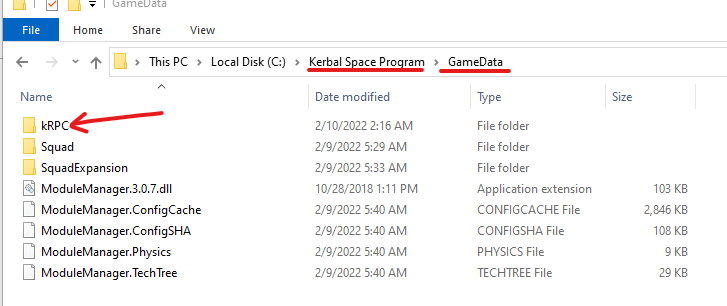

#### Prepping the jupyter workspace
If you are using Windows, [installing anaconda](https://docs.anaconda.com/anaconda/install/windows/) may be your quickest route, and then set up a kerbal environment by opensing a terminal and running:
```
conda create --name kerbal
```
You'll only need to create the envrionment once. Next activate it:
```
conda activate kerbal
```

If you are on MacOS or Linux, you can use virtualenv instead (although conda can work too).

and then install the following packages:
```
pip install setuptools==57.5.0
pip install krpc
pip install jupyter
pip install ipykernel
```

If you are using Python >= 3.8, you'll have to do a little hack. Open the file in your virtual environment files with an editor and make the following change.

FILE: `venv/lib/python3.10/site-packages/krpc/types.py`
Replace: "=`collections.Iterable` with `collections.abc.Iterable` on line 222 and 227

Next, create the kernel that we'll be using for this notebook:
```
python -m ipykernel install --user --name kerbal --display-name "Python (kerbal)"
```
and then to launch jupyter:
```
jupyter notebook
```
afterwhich you can open this notebook.

## Going to the Mun

### Connecting to KSP

In our first code blocks, we will be importing the libraries we need to get our astronauts to the Mun via Python. We will then connect to KSP vis the krpc plugin (assumes you have KSP up and running and the plugin working). 

In [1]:
import krpc
import math
import time
from IPython.display import clear_output, display

In [2]:
conn = krpc.connect()

### Loading the Apollo rocket

In [3]:
conn.space_center.load("apollo001")

In [4]:
vessel = conn.space_center.active_vessel
# Set up streams for telemetry
ut = conn.add_stream(getattr, conn.space_center, 'ut')
altitude = conn.add_stream(getattr, vessel.flight(), 'mean_altitude')
apoapsis = conn.add_stream(getattr, vessel.orbit, 'apoapsis_altitude')
stage_2_resources = vessel.resources_in_decouple_stage(stage=2, cumulative=False)

In [5]:
obt_frame = vessel.orbit.body.non_rotating_reference_frame
mun_orbit = conn.space_center.bodies["Mun"].position(obt_frame)

### Gravity Turn into Orbit

In this next section, we are calculating the gravity turn angle. The sample provided by the KRPC samples uses a simple fraction to define the trun angle in degrees:
$$ \alpha = 90(\frac{a - s}{ e - s}) $$
where $a$ is the current altitude, $s$ is the altitude in which we want to start slowly turning the rocket horizontally, and $e$ is the ending altitude where we want to have completed our turn upon reaching. This could be defined by a simple function 

In [6]:
def get_gravity_turn_angle(alt, start_alt, end_alt, turn_angle):
    new_turn_angle = 0
    if alt > start_alt and alt < end_alt:
        frac = (alt - start_alt)/(end_alt - start_alt)
        new_turn_angle = frac * 90.0
        if abs(new_turn_angle - turn_angle) > 0.5:
            turn_angle = new_turn_angle
        else:
            turn_angle = 0
    return turn_angle

In a future blog post, we will improve the gravity turn by invoking Physics to get a more accurate turn rate. For now, as a proof of concept and to focus on the circularization physics, we will proceed with this rough linear gravity turn. Next, we actually launch the rocket and execute the gravity turn so that we reach a target apoapsis:

In [7]:
vessel.auto_pilot.target_pitch_and_heading(90, 90)
vessel.auto_pilot.engage()
vessel.control.throttle = 1

In [8]:

vessel.control.activate_next_stage()

turn_angle = 0
start_alt = 250
end_alt = 45000
target_alt = 700000
state = "LiftOff"
while turn_angle >= 0 and vessel.control.throttle > 0:
    clear_output(wait=True)
    turn_angle = get_gravity_turn_angle(altitude(), start_alt, end_alt, turn_angle)
    if turn_angle != 0 and apoapsis() < target_alt:
        vessel.auto_pilot.target_pitch_and_heading(90-turn_angle, 90)
        state = "GravityTurn"
    if apoapsis() > target_alt*0.90 and apoapsis() < target_alt:
        state = "ApoapsisRefinement"
        vessel.control.throttle = 0.25
        while apoapsis() < target_alt:
                pass
    if apoapsis() >= target_alt:
        state = "GoalApoapsisAchieved"
        vessel.control.throttle = 0.00       

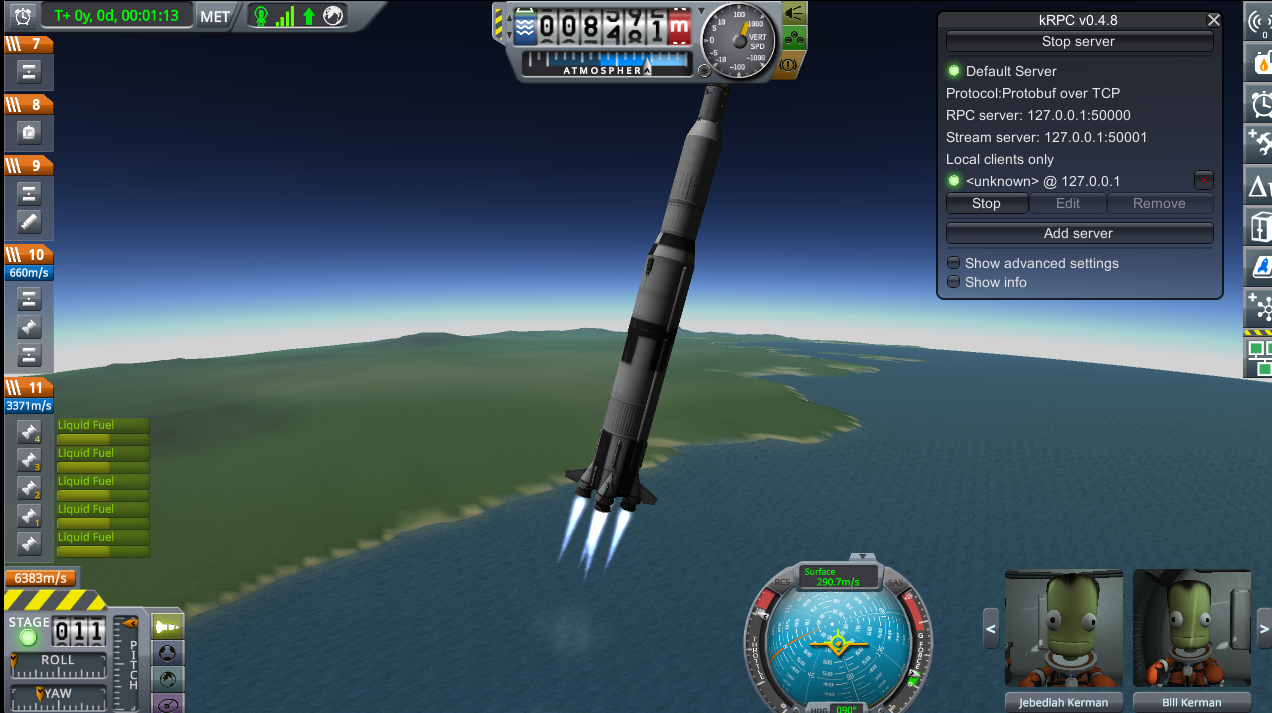

As the rocket climbs higher, it will ease into an orientation perpendicular to the radius of the Earth:

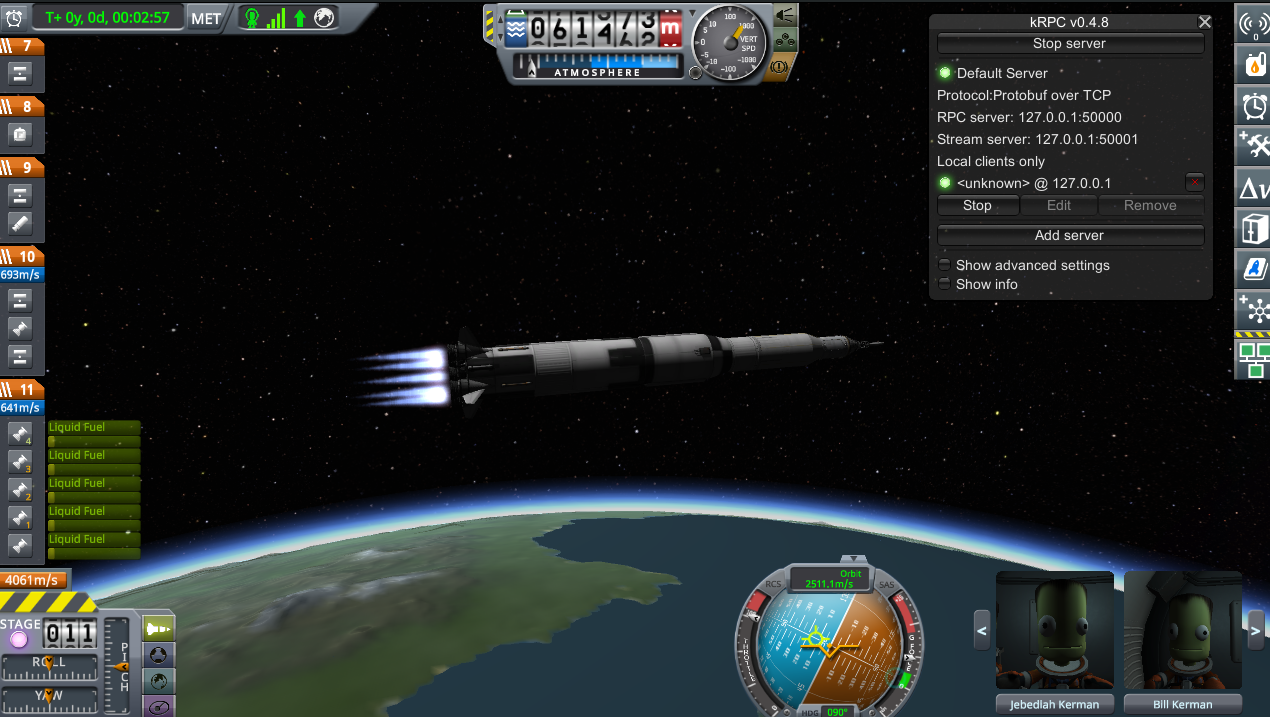

## Circularizing the orbit

For an idealized circular orbit above atmospheric effects, the gravitational pull of the Earth on the body provides the centripetal force, with circular orbital radius $r$ and let 

$$\mu = GM$$ 

where $G$ is the universal gravitational constant and $M$ is the mass of the large body (here, the Earth)

KRPC provides an easy way to access that value for any given celestial body:

In [9]:
mu = vessel.orbit.body.gravitational_parameter

Back to Physics, we now have two equations from the basics of Newtonian physics, namely:
* Cetripital Force: $$ F_c = \frac{m_0 v^2}{r}$$
* Gravitational Force: $$ F_g = \frac{m_0 GM}{r^2}$$

Since these must balance out for an object to be in stead orbit, we can solve to find the ideal velocity $v$ for a given orbit at radius $r$:

$$ F_g = m_0 a = \frac{m_0 \mu}{r^2} =\frac{m_0 v^2}{r} $$

$$\implies v = \sqrt{ \frac{\mu}{r} }$$

We see here that this velocity is entirely independent of the mass of the body, hence a very heavy object and a very light object which orbit at the same radius must be traveling at the same speed, assuming of course they are out of the region where atmospheric drag plays an important role.

### Finding an equation for the circularization of an orbit


 
 That is a starting point, but we have to dive deeper to calculate the numbers needed to actually achieve an approximation of this idealized orbit. 
 
 Our next step is to invoke the _vis-viva equation_ (or also called the _orbital-energy-invariance law_). We begin by noting that the __specific orbital energy__ of an orbiting object and the body it is orbiting is defined as a sum of their mutual potential energy and their total kinetic energy:
 
$$ E_O = E_p + E_k$$

For scenarios such as ours, where the orbiting object is much smaller in both size and mass than the body it orbits, this energy becomes easier to calculate since we can treat the larger body as being the center of our reference frame and hence at rest. We can also neglect the potential energy experienced by the gravitational attraction of the larger body by the smaller body. In this case,

$$ E_O = \frac{m_0 v^2_0}{2} - \frac{\mu m_0}{r_0} $$


The specific total energy is given as $E_o/m_0 = \epsilon$ and this is conserved throughout the orbit (assuming the rocket is not burning fuel in an idealized orbit). Let $v_a$ and $r_a$ be the velocity and radius of the orbiting body at the apoapsis, and $v_p$ and $r_p$ similarly at the periapsis. Then energy conservation gives us the relation,

$$ \epsilon = \frac{v_a^2}{2} - \frac{\mu}{r_a} = \frac{v_p^2}{2} - \frac{\mu}{r_p} $$

At both $r_a$ and $r_p$, the velocity and radius vectors are perpendicular to each other, where hence we can invoke the conservation of angular momentum to give

$$ r_p v_p = r_a v_a = \mbox{Constant} $$

This gives us the relation that
$$ v_p =- \frac{r_a}{r_p}v_a $$

and with some rearrangement of these equations, we get,

$$ \frac{1}{2}\left( \frac{r_p^2 -r_a^2}{r_p^2}\right) v_a^2 = \mu \left(\frac{1}{r_a} - \frac{1}{r_p}\right) $$
$$ \frac{1}{2}v_a^2 = \mu \frac{r_p}{r_a \left( r_p + r_a \right)} $$


#### Relating this to elipses, the apoapsis and periapsis

From geometry of an ellipse that relates the semimajor axis to $r_p$ and $r_a$, $2a = r_p + r_a$

In [10]:
r =  vessel.orbit.apoapsis
a1 = vessel.orbit.semi_major_axis

We substitute 2a in the our prior kinetic energy equation:
$$ \frac{1}{2}v_a^2 =  \mu \frac{2a -r_a}{2 r_a a}  $$
$$ \frac{1}{2}v_a^2 =  \mu \left(\frac{1}{r_a} - \frac{1}{2a}\right)  $$



 
 $$ v_a^2 = \mu \left( \frac{2}{r_a} - \frac{1}{a}\right) $$
 
 In a circularized orbit, $a = r$, and so the velocity we need to have is
 
 $$ v_a^2 = \mu \left( \frac{2}{r_a} - \frac{1}{r_a}\right) = \mu \left( \frac{1}{r_a}\right) $$
 
 The $\Delta v$ we need to achieve is the difference between these two velocities, 
 \begin{eqnarray}
      \Delta v &=& \sqrt{ \mu} \left( \sqrt{\left( \frac{1}{r_a}\right) } - \sqrt{\left( \frac{2}{r_a} - \frac{1}{a}\right)}\right) \\
      &=& \sqrt{\frac{\mu}{r_a}}\left( 1 - \sqrt{ \frac{2a -r_a}{a}}\right)
 \end{eqnarray}

In krpc code,

In [11]:
delta_v = math.sqrt(mu/r)*(1-math.sqrt((2*a1-r)/a1))

With this number in hand, we can do a little more math which will be discussed in more detail later to find the burn time. This calculation is highly dependent on the engine and design of the rocket in question:

In [12]:
f = vessel.available_thrust
Isp = vessel.specific_impulse * 9.82
m0 = vessel.mass

m1 = m0 / math.exp(delta_v / Isp)
fr = f / Isp

burn_time = (m0 - m1) / fr

In [13]:
node = vessel.control.add_node(
    ut() + vessel.orbit.time_to_apoapsis, prograde=delta_v)

In [14]:
# https://krpc.github.io/krpc/tutorials/launch-into-orbit.html

print('Orientating ship for circularization burn')

vessel.auto_pilot.disengage()
vessel.auto_pilot.sas = True
time.sleep(.1)
vessel.auto_pilot.sas_mode = vessel.auto_pilot.sas_mode.maneuver

vessel.auto_pilot.wait()

print('Waiting until circularization burn')
burn_ut = ut() + vessel.orbit.time_to_apoapsis - (burn_time/2.)
lead_time = 5
conn.space_center.warp_to(burn_ut - lead_time)
# Execute burn
print('Ready to execute burn')
time_to_apoapsis = conn.add_stream(getattr, vessel.orbit, 'time_to_apoapsis')
while time_to_apoapsis() - (burn_time/2.) > 0:
    pass
vessel.auto_pilot.wait()


print('Executing burn')
vessel.control.throttle = 1.0
time.sleep(burn_time - 0.05)
print('Fine tuning')
vessel.control.throttle = 0.05
remaining_burn = conn.add_stream(node.remaining_burn_vector, node.reference_frame)
#vessel.auto_pilot.engage()

vessel.auto_pilot.disengage()
vessel.auto_pilot.sas = True
time.sleep(.1)
vessel.auto_pilot.sas_mode = vessel.auto_pilot.sas_mode.maneuver
vessel.control.throttle = 0.03
while node.remaining_delta_v > 4:
    pass
vessel.control.throttle = 0.0
node.remove()
time.sleep(5)
print('Launch complete')

Orientating ship for circularization burn
Waiting until circularization burn
Ready to execute burn
Executing burn
Fine tuning
Launch complete


If all went well, you should be in a fairly accurate (and we can make it even better!) circularized orbit:

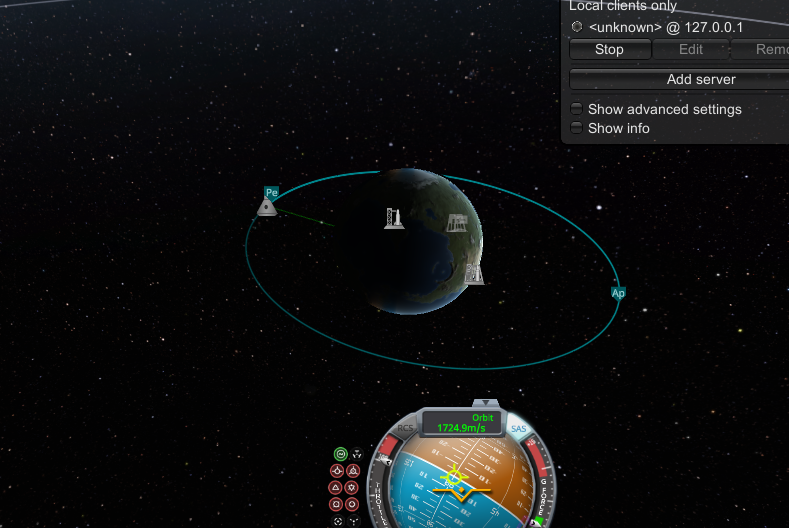

Now that we have circularized our orbit, we can do some house keeping and eject uneeded components from the rocket. In a future iteration, we will want to eject these as soon as we clear the atmosphere in order to reduce as much mass as soon as possible:

In [15]:
# Drop stage 1
vessel.control.activate_next_stage()
# Drop the escape rocket
vessel.control.activate_next_stage()
# Drop the shields to lower weight
vessel.control.activate_next_stage()

[]

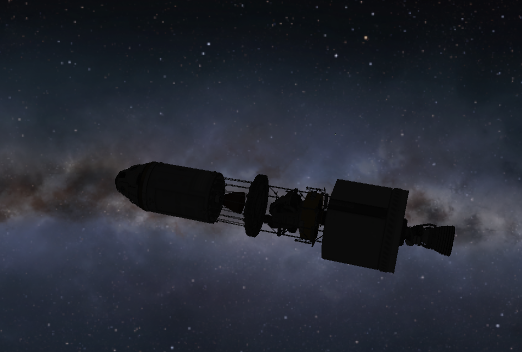